# Tugas Implementasi: Real-time Remote Photoplethysmography (rPPG)

**Mata Kuliah:** Sistem & Teknologi Multimedia  
**Nama:** Nashwa Putri Laisya  
**NIM:** 122140180  
**GitHub:** https://github.com/nashwals/multimedia/tree/main/rPPG

---

## Import Library & Konfigurasi

Pada bagian ini dilakukan import library utama yang digunakan dalam implementasi:
- OpenCV untuk membaca frame webcam, membuat GUI, dan manipulasi gambar
- MediaPipe Face Detection untuk wajah
- NumPy dan SciPy untuk pengolahan sinyal
- Matplotlib untuk plot real-time
- Deque untuk sliding window rPPG

Konfigurasi seperti bandpass range, sliding window, dan inisialisasi MediaPipe juga didefinisikan di sini.

In [1]:
import cv2
import time
import numpy as np
from collections import deque

import mediapipe as mp
from scipy.signal import butter, filtfilt, detrend
import matplotlib.pyplot as plt

# Untuk plot interaktif real-time
plt.ion()

# Konfigurasi umum
WINDOW_SECONDS = 20.0        # panjang window sliding ~20 detik
BPM_MIN = 40
BPM_MAX = 180
FREQ_MIN = BPM_MIN / 60.0    # 0.67 Hz
FREQ_MAX = BPM_MAX / 60.0    # 3.0 Hz

# Inisialisasi MediaPipe
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

---

## Fungsi Utilitas Sinyal (Filter + FFT → BPM)

Bagian ini menyediakan fungsi penting untuk pemrosesan sinyal:

- `butter_bandpass` & `bandpass_filter`     
    Digunakan untuk menyaring sinyal menggunakan bandpass filter dengan rentang frekuensi detak jantung manusia (sekitar 0.67–3.0 Hz).

- `estimate_bpm_fft`        
    Melakukan FFT pada sinyal rPPG dan mengambil frekuensi dominan dalam rentang valid untuk dihitung sebagai BPM.

Fungsi ini menjadi komponen utama dalam estimasi heart rate.

In [2]:
# Fungsi Utilitas: Filter dan FFT
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(signal, fs, lowcut=FREQ_MIN, highcut=FREQ_MAX, order=3):
    # Cek panjang minimum sinyal untuk filter
    # filtfilt butuh sinyal lebih panjang dari padlen (default 3 * max(len(a), len(b)))
    min_length = 3 * (order + 1) * 2  # Estimasi konservatif
    
    if len(signal) < min_length:
        return signal
    
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    
    # Gunakan padlen yang lebih kecil untuk sinyal pendek
    padlen = min(len(signal) // 2 - 1, 3 * max(len(a), len(b)))
    if padlen < 1:
        return signal
    
    try:
        filtered = filtfilt(b, a, signal, padlen=padlen)
        return filtered
    except ValueError:
        # Jika masih error, return sinyal asli
        return signal

def estimate_bpm_fft(signal, timestamps):
    """
    Estimasi BPM menggunakan FFT dari sinyal 1D.
    timestamps: array of time (detik)
    """
    if len(signal) < 2:
        return None, None, None

    # Hitung sampling rate dari timestamps (lebih robust dari fps asumsi)
    duration = timestamps[-1] - timestamps[0]
    if duration <= 0:
        return None, None, None
    fs = len(signal) / duration

    # Detrend & bandpass
    sig = detrend(signal)
    sig = bandpass_filter(sig, fs, lowcut=FREQ_MIN, highcut=FREQ_MAX)

    # FFT
    N = len(sig)
    freqs = np.fft.rfftfreq(N, d=1.0/fs)
    fft_vals = np.abs(np.fft.rfft(sig))

    # Batasi ke rentang detak jantung manusia
    valid_idx = np.where((freqs >= FREQ_MIN) & (freqs <= FREQ_MAX))[0]
    if len(valid_idx) == 0:
        return None, freqs, fft_vals

    peak_idx = valid_idx[np.argmax(fft_vals[valid_idx])]
    peak_freq = freqs[peak_idx]

    bpm = peak_freq * 60.0
    return bpm, freqs, fft_vals

---

## POS Method

Menggunakan POS (Plane-Orthogonal-to-Skin) sebagai metode inti ekstraksi rPPG modern.

POS bekerja dengan:
1) Menghilangkan mean RGB (normalize)
2) Menggunakan proyeksi matriks 2D
3) Menggabungkan perubahan warna tertentu untuk membentuk sinyal rPPG

Keunggulan:
- Lebih stabil dibanding green-channel-only
- Lebih tahan terhadap gerakan kecil
- Lebih baik dalam kondisi cahaya tidak ideal

Sinyal yang dihasilkan POS digunakan untuk FFT.

In [3]:
# POS Method untuk rPPG
def pos_method(rgb_trace):
    """
    rgb_trace: array shape (N, 3) -> [R, G, B] per sampel
    return: sinyal 1D hasil POS (panjang N)
    """
    C = np.asarray(rgb_trace, dtype=np.float64)  # (N, 3)
    if C.ndim != 2 or C.shape[1] != 3:
        raise ValueError("rgb_trace harus shape (N, 3)")

    # Normalisasi dengan mengurangi mean per channel
    C = C - np.mean(C, axis=0, keepdims=True)

    # Matriks proyeksi POS (2 x 3)
    # diambil dari paper "Plane-Orthogonal-to-Skin (POS)..." (Wang et al.)
    projection = np.array([[0, 1, -1],
                           [-2, 1, 1]], dtype=np.float64)

    S = C.dot(projection.T)     # (N, 2)

    # Normalisasi tiap baris dengan std
    S_std = np.std(S, axis=0, ddof=1)
    S_std[S_std == 0] = 1.0
    S_norm = S / S_std

    # Kombinasi jadi satu sinyal
    h = S_norm[:, 0] + S_norm[:, 1]
    return h

---

## Skin Segmentation (simple HSV mask di ROI)

Skin segmentation ditambahkan untuk membantu memastikan hanya piksel kulit yang diproses.
Metode:
- Konversi ROI menjadi HSV
- Dua range warna kulit (low & high hue)
- Morphological filtering untuk menghaluskan mask

Jika mask terlalu sedikit (tidak ada kulit terdeteksi), sistem fallback ke ROI asli.

In [4]:
# Skin Segmentation Sederhana (HSV)
def skin_mask_hsv(bgr_roi):
    """
    bgr_roi: ROI dalam BGR
    return: mask biner (uint8) dengan nilai 0/255
    """
    hsv = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2HSV)

    # rentang kulit sederhana (bisa di-tune nanti)
    lower1 = np.array([0, 30, 60], dtype=np.uint8)
    upper1 = np.array([20, 150, 255], dtype=np.uint8)

    lower2 = np.array([160, 30, 60], dtype=np.uint8)
    upper2 = np.array([180, 150, 255], dtype=np.uint8)

    mask1 = cv2.inRange(hsv, lower1, upper1)
    mask2 = cv2.inRange(hsv, lower2, upper2)
    mask = cv2.bitwise_or(mask1, mask2)

    # Sedikit smoothing
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.medianBlur(mask, 3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask

---

## Kelas rPPG Processor (Buffer + Sliding Window + BPM)

Bagian ini membungkus seluruh pipeline sinyal ke dalam sebuah class.

Fitur utama:

- Buffer RGB & Timestamp (deque)        
    Digunakan untuk sliding window sepanjang window_seconds.

- `compute_bpm()`
    - Memanggil POS method
    - Filtering
    - FFT
    - Menghasilkan BPM

- BPM Smoothing     
    Menggunakan rata-rata bergerak dari beberapa BPM terakhir agar nilai yang ditampilkan tidak terlalu fluktuatif.

- Real-time plot updater    
Meng-update:
    - Grafik sinyal waktu (POS output)
    - Spektrum FFT (frekuensi)

Dengan `plt.pause()` untuk menjaga responsivitas.

In [5]:
# rPPG Processor dengan BPM Smoothing
class RPPGProcessor:
    def __init__(self, window_seconds=WINDOW_SECONDS):
        self.window_seconds = window_seconds
        self.rgb_buffer = deque()
        self.time_buffer = deque()
        
        # Buffer untuk smoothing BPM display
        self.bpm_history = deque(maxlen=5)  # Simpan 5 BPM terakhir
        self.last_valid_bpm = None
        
        # Counter untuk update plot (tidak setiap frame)
        self.frame_counter = 0
        self.plot_update_interval = 5  # Update plot setiap 5 frame

        # Untuk plotting real-time
        self.fig, (self.ax_signal, self.ax_fft) = plt.subplots(2, 1, figsize=(6, 6))
        self.line_signal, = self.ax_signal.plot([], [])
        self.line_fft, = self.ax_fft.plot([], [])
        self.ax_signal.set_title("POS rPPG Signal")
        self.ax_fft.set_title("FFT Spectrum")
        self.ax_signal.set_xlabel("Time (s)")
        self.ax_fft.set_xlabel("Frequency (Hz)")
        self.ax_signal.set_ylabel("Amplitude")
        self.ax_fft.set_ylabel("Magnitude")
        self.fig.tight_layout()

    def add_sample(self, rgb, timestamp):
        """
        rgb: tuple/list (R, G, B)
        timestamp: time.time()
        """
        self.rgb_buffer.append(rgb)
        self.time_buffer.append(timestamp)

        # Buang data yang lebih lama dari window_seconds
        while self.time_buffer and (self.time_buffer[-1] - self.time_buffer[0] > self.window_seconds):
            self.rgb_buffer.popleft()
            self.time_buffer.popleft()

    def compute_bpm(self):
        if len(self.rgb_buffer) < 30:  # Minimal 30 samples (~1 detik)
            return None, None, None, None

        rgb_arr = np.array(self.rgb_buffer)  # (N, 3)
        t_arr = np.array(self.time_buffer)

        try:
            # POS method -> sinyal 1D
            h = pos_method(rgb_arr)
            bpm, freqs, fft_vals = estimate_bpm_fft(h, t_arr)
            
            # Validasi BPM (harus dalam range realistis)
            if bpm is not None and BPM_MIN <= bpm <= BPM_MAX:
                self.bpm_history.append(bpm)
                self.last_valid_bpm = bpm
            
            return bpm, h, freqs, fft_vals
            
        except Exception as e:
            print(f"Error computing BPM: {e}")
            return None, None, None, None
    
    def get_smoothed_bpm(self):
        """
        Return BPM yang sudah di-smooth dengan moving average
        """
        if len(self.bpm_history) == 0:
            return self.last_valid_bpm
        
        # Moving average dari 5 BPM terakhir
        return np.mean(list(self.bpm_history))

    def should_update_plot(self):
        """
        Cek apakah sudah waktunya update plot (untuk performa)
        """
        self.frame_counter += 1
        if self.frame_counter >= self.plot_update_interval:
            self.frame_counter = 0
            return True
        return False

    def update_plots(self, h, freqs, fft_vals):
        if h is None or freqs is None or fft_vals is None:
            return
        
        if not self.should_update_plot():
            return

        t_arr = np.array(self.time_buffer)
        t_rel = t_arr - t_arr[0]

        # Update time-domain signal
        self.ax_signal.clear()
        self.ax_signal.plot(t_rel, h, 'b-', linewidth=1)
        self.ax_signal.set_title("POS rPPG Signal")
        self.ax_signal.set_xlabel("Time (s)")
        self.ax_signal.set_ylabel("Amplitude")
        self.ax_signal.grid(True, alpha=0.3)

        # Update FFT dengan highlight peak
        self.ax_fft.clear()
        self.ax_fft.plot(freqs, fft_vals, 'r-', linewidth=1)
        
        # Highlight peak frequency
        valid_idx = np.where((freqs >= FREQ_MIN) & (freqs <= FREQ_MAX))[0]
        if len(valid_idx) > 0:
            peak_idx = valid_idx[np.argmax(fft_vals[valid_idx])]
            self.ax_fft.plot(freqs[peak_idx], fft_vals[peak_idx], 'go', markersize=10)
        
        self.ax_fft.set_xlim(FREQ_MIN, FREQ_MAX)
        self.ax_fft.set_title("FFT Spectrum (Heart Rate Range)")
        self.ax_fft.set_xlabel("Frequency (Hz)")
        self.ax_fft.set_ylabel("Magnitude")
        self.ax_fft.grid(True, alpha=0.3)

        self.fig.tight_layout()
        plt.pause(0.01)  # Minimal pause untuk responsiveness

---

## Deteksi Wajah & ROI Pipi dengan MediaPipe

Program yang saya buat ini tidak menggunakan dahi, tetapi menggunakan dua ROI pipi (cheeks):
- ROI diambil berdasarkan bounding box wajah
- Digunakan area yang cukup stabil untuk rPPG
- Dipadukan menjadi satu sinyal (R,G,B mean)

Koordinat ROI dihitung dari posisi bounding box MediaPipe:
- 20–80% lebar wajah (center area)
- 45–75% tinggi wajah (area pipi)

ROI ini dipilih karena:
- Tidak terlalu terpengaruh rambut atau bayangan
- Umumnya memiliki tekstur kulit yang baik untuk rPPG
- Lebih stabil untuk gerakan kecil dibanding dahi

In [6]:
# Fungsi untuk Mengambil ROI Pipi (Cheeks)

def get_cheek_roi(frame, detection):
    """
    Ambil ROI pipi kanan berdasarkan bounding box wajah dari MediaPipe.
    
    Args:
        frame: Frame BGR dari webcam
        detection: MediaPipe face detection object
        
    Returns:
        tuple: (cheek_x1, cheek_y1, cheek_x2, cheek_y2)
    
    ROI Strategy untuk Pipi:
    - Vertikal: Ambil 40%-70% dari tinggi wajah (area pipi, di bawah mata)
    - Horizontal: Ambil 60%-90% dari lebar wajah (pipi kanan)
    
    Pipi dipilih karena:
    1. Area kulit yang luas dan stabil
    2. Minim gerakan dibanding dahi (tidak ada alis)
    3. Perfusi darah yang baik untuk sinyal rPPG
    """
    h, w, _ = frame.shape
    relative_bbox = detection.location_data.relative_bounding_box
    
    # Koordinat bounding box wajah
    x = int(relative_bbox.xmin * w)
    y = int(relative_bbox.ymin * h)
    bw = int(relative_bbox.width * w)
    bh = int(relative_bbox.height * h)

    # ROI Pipi Kanan - Optimized untuk rPPG
    # Vertikal: 40%-70% dari tinggi wajah (area pipi, antara mata dan mulut)
    cheek_y1 = max(y + int(0.40 * bh), 0)  # Mulai dari 40% (di bawah mata)
    cheek_y2 = min(y + int(0.70 * bh), h)  # Sampai 70% tinggi wajah (di atas dagu)
    
    # Horizontal: 60%-90% dari lebar wajah (pipi kanan)
    cheek_x1 = max(x + int(0.60 * bw), 0)  # 60% dari kiri bbox
    cheek_x2 = min(x + int(0.90 * bw), w)  # 90% dari kiri bbox (tepi kanan)

    return cheek_x1, cheek_y1, cheek_x2, cheek_y2

---

## Loop Real-time Webcam + GUI

✅ Webcam berhasil dibuka
📹 Tekan 'q' atau ESC untuk keluar
⏱️  Tunggu ~5 detik untuk hasil BPM yang stabil...
👤 ROI: Pipi kanan untuk deteksi rPPG



I0000 00:00:1764750714.553746  397676 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764750714.574309  398657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/nashwalaisya/multimedia-uv-py312/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


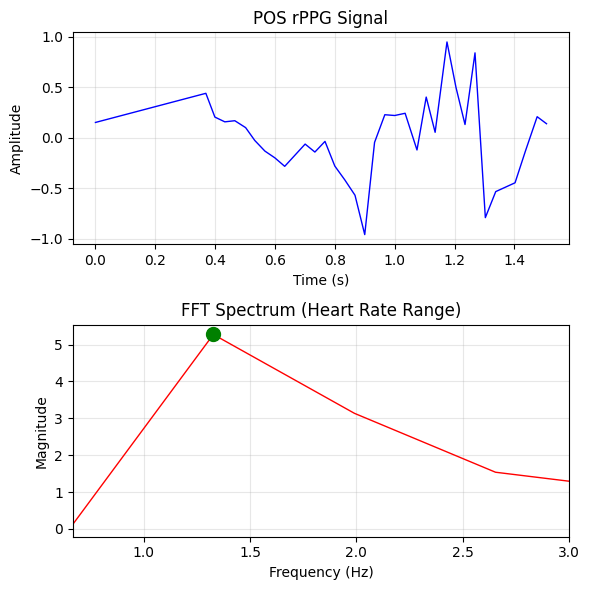


🛑 Program dihentikan oleh user

📊 STATISTIK AKHIR:
   Total samples: 394
   Last BPM: 56.0
   Avg BPM: 56.2
   Std BPM: 0.2


In [7]:
# Loop Real-time Webcam + GUI dengan Error Handling
cap = cv2.VideoCapture(0)  # 0 = default webcam

if not cap.isOpened():
    print("❌ GAGAL: Tidak bisa membuka webcam!")
    print("Pastikan webcam terhubung dan tidak digunakan aplikasi lain.")
else:
    print("✅ Webcam berhasil dibuka")
    print("📹 Tekan 'q' atau ESC untuk keluar")
    print("⏱️  Tunggu ~5 detik untuk hasil BPM yang stabil...")
    print("👤 ROI: Pipi kanan untuk deteksi rPPG\n")
    
    rppg = RPPGProcessor(window_seconds=WINDOW_SECONDS)
    frame_count = 0
    fps_start_time = time.time()
    current_fps = 0

    with mp_face_detection.FaceDetection(
        model_selection=0,  # 0: dekat, 1: jauh
        min_detection_confidence=0.5
    ) as face_detection:

        while True:
            ret, frame = cap.read()
            if not ret:
                print("⚠️  Frame tidak terbaca, mencoba lagi...")
                continue

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_detection.process(frame_rgb)

            bpm_display = None
            signal_quality = "Mencari wajah..."

            if results.detections:
                # Ambil deteksi wajah pertama saja
                detection = results.detections[0]
                signal_quality = "Wajah terdeteksi"

                # Dapatkan bounding box wajah
                h, w, _ = frame.shape
                relative_bbox = detection.location_data.relative_bounding_box
                x = int(relative_bbox.xmin * w)
                y = int(relative_bbox.ymin * h)
                bw = int(relative_bbox.width * w)
                bh = int(relative_bbox.height * h)
                
                # ROI Pipi menggunakan fungsi get_cheek_roi
                cheek_x1, cheek_y1, cheek_x2, cheek_y2 = get_cheek_roi(frame, detection)
                cheek_roi = frame[cheek_y1:cheek_y2, cheek_x1:cheek_x2]

                if cheek_roi.size > 0:
                    try:
                        # Skin segmentation
                        mask = skin_mask_hsv(cheek_roi)
                        mask_3c = cv2.merge([mask, mask, mask])
                        masked_roi = cv2.bitwise_and(cheek_roi, mask_3c)

                        # Cek apakah ada cukup piksel kulit
                        skin_ratio = np.count_nonzero(mask) / mask.size
                        
                        if skin_ratio < 0.1:  # Kurang dari 10% kulit terdeteksi
                            roi_used = cheek_roi
                            signal_quality = "Skin detection lemah"
                        else:
                            roi_used = masked_roi
                            signal_quality = f"Skin: {skin_ratio*100:.1f}%"

                        # Hitung mean RGB dari ROI
                        roi_rgb = cv2.cvtColor(roi_used, cv2.COLOR_BGR2RGB)
                        r_mean = np.mean(roi_rgb[:, :, 0])
                        g_mean = np.mean(roi_rgb[:, :, 1])
                        b_mean = np.mean(roi_rgb[:, :, 2])
                        
                        # Validasi: RGB tidak boleh terlalu gelap atau terlalu terang
                        if r_mean > 20 and g_mean > 20 and b_mean > 20:
                            timestamp = time.time()
                            rppg.add_sample((r_mean, g_mean, b_mean), timestamp)
                            
                            bpm, h, freqs, fft_vals = rppg.compute_bpm()

                            # Update grafik real-time
                            if bpm is not None and BPM_MIN <= bpm <= BPM_MAX:
                                bpm_display = rppg.get_smoothed_bpm()  # Gunakan smoothed BPM
                                rppg.update_plots(h, freqs, fft_vals)
                                signal_quality = "✓ Sinyal bagus"
                            elif len(rppg.rgb_buffer) < 30:
                                signal_quality = f"Mengumpulkan data: {len(rppg.rgb_buffer)}/30"
                            else:
                                signal_quality = "Sinyal lemah"
                        else:
                            signal_quality = "ROI terlalu gelap"

                        # Gambar ROI pipi di frame (warna cyan untuk membedakan dari dahi)
                        cv2.rectangle(frame, (cheek_x1, cheek_y1), 
                                    (cheek_x2, cheek_y2), (255, 255, 0), 2)
                        cv2.putText(frame, "Cheek ROI", (cheek_x1, cheek_y1 - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
                        
                    except Exception as e:
                        signal_quality = f"Error: {str(e)[:20]}"

                # Gambar bounding box wajah
                cv2.rectangle(frame, (x, y), (x + bw, y + bh), (255, 255, 0), 1)

            # Hitung FPS
            frame_count += 1
            if frame_count % 30 == 0:
                current_fps = 30 / (time.time() - fps_start_time)
                fps_start_time = time.time()

            # === UI Display ===
            # Background panel untuk info
            cv2.rectangle(frame, (10, 10), (380, 140), (0, 0, 0), -1)
            cv2.rectangle(frame, (10, 10), (380, 140), (0, 255, 0), 2)
            
            # BPM Display (besar)
            if bpm_display is not None:
                text = f"HR: {bpm_display:.1f} BPM"
                color = (0, 255, 0)  # Hijau jika valid
            else:
                text = "HR: --.- BPM"
                color = (0, 165, 255)  # Orange jika belum ada
            
            cv2.putText(frame, text, (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)
            
            # Signal Quality
            cv2.putText(frame, f"Status: {signal_quality}", (20, 85),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
            # Buffer Info
            buffer_size = len(rppg.rgb_buffer)
            cv2.putText(frame, f"Buffer: {buffer_size} samples", (20, 105),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
            # FPS
            cv2.putText(frame, f"FPS: {current_fps:.1f}", (20, 125),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            cv2.imshow("rPPG Monitor - Nashwa (122140180)", frame)

            key = cv2.waitKey(1) & 0xFF
            if key == 27 or key == ord('q'):  # Esc atau q
                print("\n🛑 Program dihentikan oleh user")
                break

    cap.release()
    cv2.destroyAllWindows()
    plt.ioff()
    
    print("\n" + "="*50)
    print("📊 STATISTIK AKHIR:")
    print(f"   Total samples: {len(rppg.rgb_buffer)}")
    if rppg.last_valid_bpm:
        print(f"   Last BPM: {rppg.last_valid_bpm:.1f}")
    if len(rppg.bpm_history) > 0:
        print(f"   Avg BPM: {np.mean(list(rppg.bpm_history)):.1f}")
        print(f"   Std BPM: {np.std(list(rppg.bpm_history)):.1f}")
    print("="*50)
    
    plt.show()


---

## Penjelasan Program

### 1. Ringkasan Pekerjaan

Program ini membangun pipeline rPPG lengkap mulai dari pengambilan frame webcam, deteksi wajah, ekstraksi sinyal dari ROI, pemrosesan sinyal, estimasi BPM, hingga visualisasi real-time. Pipeline dasar yang diimplementasikan meliputi:
1. Face Detection → menggunakan MediaPipe Face Detection
2. ROI Extraction → pemilihan area pipi kanan sebagai area sinyal rPPG
3. Spatial Averaging → menghitung rata-rata intensitas R, G, B pada ROI
4. Signal Preprocessing
    - Detrending
    - Bandpass filter (0.67 – 3.0 Hz)
5. Heart Rate Estimation → melalui FFT untuk menentukan frekuensi dominan
6. Real-time Processing → sliding window 20 detik dengan pembaruan BPM berkelanjutan

Hasil BPM ditampilkan langsung pada frame webcam dan diperkuat dengan grafik sinyal waktu (time-domain) serta spektrum FFT (frequency-domain).


### 2. Perbedaan & Peningkatan Dibanding Demo Kelas

Saya menambahkan beberapa pemrosesan lanjutan dan teknik peningkatan kualitas, yaitu:

1. POS Method (Plane-Orthogonal-to-Skin)        
    Dipakai sebagai metode ekstraksi sinyal rPPG yang lebih robust terhadap variasi cahaya dan gerakan. POS digunakan sebagai sinyal utama untuk estimasi BPM.

2. Skin Segmentation (HSV)      
    Memastikan hanya area kulit yang berkontribusi pada sinyal rPPG. Sistem menghitung skin ratio dan melakukan fallback cerdas bila deteksi kulit terlalu lemah.

3. ROI Pipi     
    ROI pipi dihitung secara proporsional dari bounding box wajah.

4. Visualisasi Real-time        
    Sistem menampilkan dua grafik interaktif:
    - Sinyal rPPG (POS) dalam domain waktu
    - Spektrum FFT dengan penandaan frekuensi puncak

---

## Credit & Referensi

- ChatGPT: https://chatgpt.com/share/692fea47-1a1c-8004-867c-170e8c3da8cc
- Copilot VSCode (percakapan dilampirkan di bawah)

**Prompt:**

tolong ubah fokus ROI dari dahi menjadi ke pipi



**Copilot:**
Saya akan mengubah ROI dari dahi menjadi pipi. Mari saya update fungsi `get_forehead_roi` menjadi fungsi untuk ROI pipi: 

Retrieving Notebook summary.

Sekarang saya akan mengubah fungsi ROI dan implementasinya untuk fokus ke pipi: 

Edit [](file:///Users/nashwalaisya/Documents/Semester%20-%207/Sistem%20Teknologi%20Multimedia/GitHub/rPPG/rppg.ipynb)

Edit [](file:///Users/nashwalaisya/Documents/Semester%20-%207/Sistem%20Teknologi%20Multimedia/GitHub/rPPG/rppg.ipynb)

Edit [](file:///Users/nashwalaisya/Documents/Semester%20-%207/Sistem%20Teknologi%20Multimedia/GitHub/rPPG/rppg.ipynb)

Selesai! ROI telah diubah dari dahi ke pipi. Perubahan yang dilakukan:

**✅ Perubahan utama:**

1. **Cell 12 (Markdown)** - Judul diubah dari "Deteksi Wajah & ROI Dahi" → "Deteksi Wajah & ROI Pipi"

2. **Cell 13 - Fungsi `get_cheek_roi()`:**
   - Nama fungsi: `get_forehead_roi()` → `get_cheek_roi()`
   - **Vertikal:** 40%-70% dari tinggi wajah (area pipi antara mata dan mulut)
   - **Horizontal:** 60%-90% dari lebar wajah (pipi kanan)
   - Dokumentasi lengkap mengapa pipi dipilih: area kulit luas, stabil, perfusi darah bagus

3. **Cell 15 - Main Loop:**
   - Memanggil `get_cheek_roi()` bukan `get_forehead_roi()`
   - Variabel `cheek_x1, cheek_y1, cheek_x2, cheek_y2` untuk koordinat pipi
   - ROI box berwarna kuning (yellow) dengan label "Cheek ROI"
   - Info tambahan di print statement tentang ROI pipi

**Keuntungan ROI Pipi:**
- ✅ Area kulit lebih luas dan stabil
- ✅ Minim gerakan (tidak ada alis yang bergerak)
- ✅ Perfusi darah baik untuk sinyal PPG
- ✅ Lebih mudah terdeteksi dengan skin segmentation

Silakan **jalankan Cell 15** untuk melihat deteksi rPPG menggunakan ROI pipi! 👤💓

Made changes.